# Exercise 4.7

In [1]:
import numpy as np
from typing import Tuple
from scipy.stats import poisson
import matplotlib.pyplot as plt

## Replicating the original problem

In [2]:
def generatePoisson(length, lam):
	probs = np.zeros(length)
	for i in range(length):
		probs[i] += poisson.pmf(i, lam)
	probs[length - 1] += 1 - sum(probs)	#The remainding probabilities are all bigger
	return probs

class RentalMDP():
	
	def __init__(self, max_cars, max_transfer):
		self.max_cars = max_cars
		self.max_transfer = max_transfer
		self.InitializeTransitionStatesAndProbsAndRequests()
	
	
	def InitializeTransitionStatesAndProbsAndRequests(self):

		#The requests of the cars:
		prob1_request = generatePoisson(self.max_cars + 1, 3)
		prob2_request = generatePoisson(self.max_cars + 1, 4)
		
		#The returns of the cars:
		prob1_return = generatePoisson(self.max_cars + 1, 3)
		prob2_return = generatePoisson(self.max_cars + 1, 2)
		
		#The full probabilities:
		#Start state, next state, rented -> prob
		prob1_full = {}
		for state1 in range(self.max_cars + 1):
			for req in range(self.max_cars + 1):
				for ret in range(self.max_cars + 1):
					state_after_rent = max(state1 - req, 0)
					rented = state1 - state_after_rent
					state_after_return = min(self.max_cars, state_after_rent + ret)

					if (state1, state_after_return, rented) not in prob1_full:
						prob1_full[(state1, state_after_return, rented)] = prob1_request[req] * prob1_return[ret]
					else:
						prob1_full[(state1, state_after_return, rented)] += prob1_request[req] * prob1_return[ret]

		prob2_full = {}
		for state2 in range(self.max_cars + 1):
			for req in range(self.max_cars + 1):
				for ret in range(self.max_cars + 1):
					state_after_rent = max(state2 - req, 0)
					rented = state2 - state_after_rent
					state_after_return = min(self.max_cars, state_after_rent + ret)
					
					if (state2, state_after_return, rented) not in prob2_full:
						prob2_full[(state2, state_after_return, rented)] = prob2_request[req] * prob2_return[ret]
					else:
						prob2_full[(state2, state_after_return, rented)] += prob2_request[req] * prob2_return[ret]

		self.TransitionStatesAndProbsAndRequests = {}
		self.TransitionStatesAndProbs = {}
		for (state1, state1_next, rented1), prob1 in prob1_full.items():
			for (state2, state2_next, rented2), prob2 in prob2_full.items():			
				if (state1, state2) not in self.TransitionStatesAndProbsAndRequests:
					self.TransitionStatesAndProbsAndRequests[(state1,state2)] = {}
				if ((state1_next,state2_next), rented1 + rented2) not in self.TransitionStatesAndProbsAndRequests[(state1,state2)]:
					self.TransitionStatesAndProbsAndRequests[(state1,state2)][((state1_next,state2_next), rented1 + rented2)] = 0
				self.TransitionStatesAndProbsAndRequests[(state1,state2)][((state1_next,state2_next), rented1 + rented2)] += prob1 * prob2			


				if (state1, state2) not in self.TransitionStatesAndProbs:
					self.TransitionStatesAndProbs[(state1,state2)] = {}
				if (state1_next,state2_next) not in self.TransitionStatesAndProbs[(state1,state2)]:
					self.TransitionStatesAndProbs[(state1,state2)][(state1_next,state2_next)] = 0
				self.TransitionStatesAndProbs[(state1,state2)][(state1_next,state2_next)] += prob1 * prob2	
		#self.prob1_full = prob1_full
		#self.prob2_full = prob2_full
											
					

	def getPossibleActions(self, state: Tuple[int,int]):
		firstToSecond = -min(state[0], self.max_cars - state[1], self.max_transfer)
		secondToFirst = min(state[1], self.max_cars - state[0], self.max_transfer)
		return list(range(firstToSecond, secondToFirst + 1))


	def getStates(self):
		states = []
		for i in range(self.max_cars + 1):
			for j in range(self.max_cars + 1):
				states.append((i,j))
		return states

	def getTransitionStatesAndProbsAndRequests(self, state: Tuple[int,int], action):
		new_state = (state[0] + action, state[1] - action)
		return self.TransitionStatesAndProbsAndRequests[new_state]
	
	def getTransitionStatesAndProbs(self, state: Tuple[int,int], action):
		new_state = (state[0] + action, state[1] - action)
		return self.TransitionStatesAndProbs[new_state]
		


	def getExpectedReward(self, state, action):
		pass

In [3]:
class OriginalRentalMdp(RentalMDP):
	def __init__(self, max_cars, max_transfer):
		super().__init__(max_cars, max_transfer)
	

	def getExpectedReward(self, state, action):
		rew = - abs(action) * 2
		transitions = self.getTransitionStatesAndProbsAndRequests(state, action)
		for (next_state, rented), prob in transitions.items():
			rew += 10 * rented * prob
		return rew
		

In [4]:
class PolicyIterationAgent():

	def __init__(self, mdp, discount = 0.9):
		self.mdp = mdp
		self.discount = discount

		states = self.mdp.getStates()
		self.state_policies = {}
		self.state_values = {}
		for s in states:
			self.state_policies[s] = 0
			self.state_values[s] = 0

		
		policy_stable = False
		while (not policy_stable):
			delta = float('inf')
			while(0.00001 < delta):
				delta = 0
				for s in states:
					v = self.state_values[s]

					transitions = mdp.getTransitionStatesAndProbs(s, self.state_policies[s])
					v_ = mdp.getExpectedReward(s, self.state_policies[s])
					for next_state, prob in transitions.items():
						v_ += prob * self.discount * self.state_values[next_state]
					self.state_values[s] = v_
					delta = max(abs(v - self.state_values[s]), delta)

			policy_stable = True
			for s in states:
				old_action = self.state_policies[s]

				possible_actions = self.mdp.getPossibleActions(s)
				best_action = None
				best_v_value = float('-inf')
				#print(s, end = " ")
				for a in possible_actions:
					v_ = mdp.getExpectedReward(s, a)
					#print(v_, end =" ")
					transitions = mdp.getTransitionStatesAndProbs(s, a)
					for next_state, prob in transitions.items():
						v_ += prob * self.discount * self.state_values[next_state]
					if v_ > best_v_value:
						best_action = a
						best_v_value = v_
				
				self.state_policies[s] = best_action
				if old_action != self.state_policies[s]:
					policy_stable = False
				



In [5]:
original_mdp = OriginalRentalMdp(20,5)

In [6]:
agent = PolicyIterationAgent(original_mdp, 0.9)

In [7]:
policies = np.empty((21,21))
values = np.empty((21,21))
for i in range(21):
    for j in range(21):
        policies[i,j] = agent.state_policies[(i,j)]
        values[i,j] = agent.state_values[(i,j)]

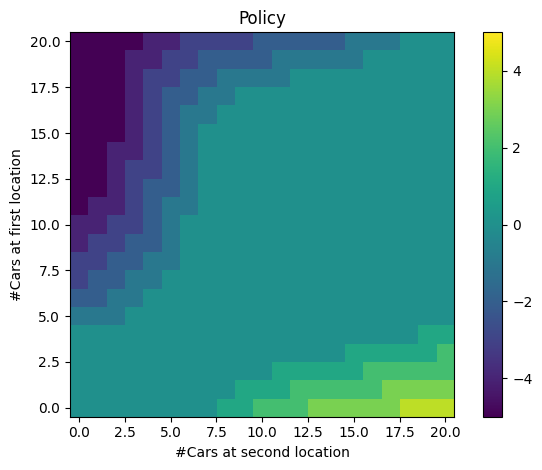

In [8]:
plt.figure()
plt.title("Policy")
plt.ylabel("#Cars at first location")
plt.xlabel("#Cars at second location")
plt.imshow(policies , origin='lower',
            vmin=-5, vmax=+5)
plt.colorbar()
plt.tight_layout()
plt.savefig('../chapters_latex/figures/ex_04_07_original.pdf')

(This is exactly the same policy that was in the book)

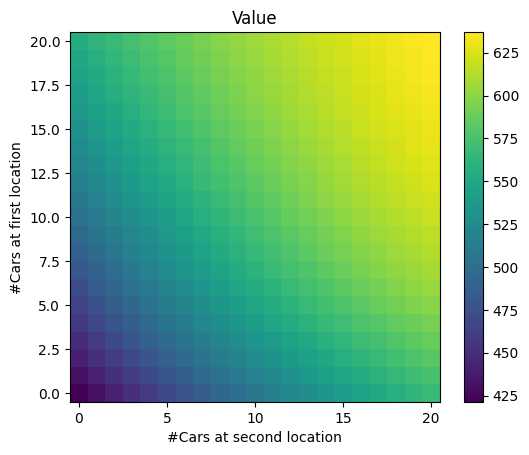

In [9]:
plt.figure()
plt.title("Value")
plt.ylabel("#Cars at first location")
plt.xlabel("#Cars at second location")
plt.imshow(values , origin='lower')
plt.colorbar()

## Solving the new problem

In [10]:
class NewRentalMdp(RentalMDP):
	def __init__(self, max_cars, max_transfer):
		super().__init__(max_cars, max_transfer)
	

	def getExpectedReward(self, state, action):
		if action > 0:
			rew = - (action - 1) * 2
		else:
			rew = action * 2
		new_state = (state[0] + action, state[1] - action)
		if new_state[0] > 10:
			rew -= 4
		if new_state[1] > 10:
			rew -= 4

		transitions = self.getTransitionStatesAndProbsAndRequests(state, action)
		for (next_state, rented), prob in transitions.items():
			rew += 10 * rented * prob
			
		return rew

In [11]:
new_mdp = NewRentalMdp(20,5)

In [12]:
new_agent = PolicyIterationAgent(new_mdp, 0.9)

In [13]:
policies = np.empty((21,21))
values = np.empty((21,21))
for i in range(21):
    for j in range(21):
        policies[i,j] = new_agent.state_policies[(i,j)]
        values[i,j] = new_agent.state_values[(i,j)]

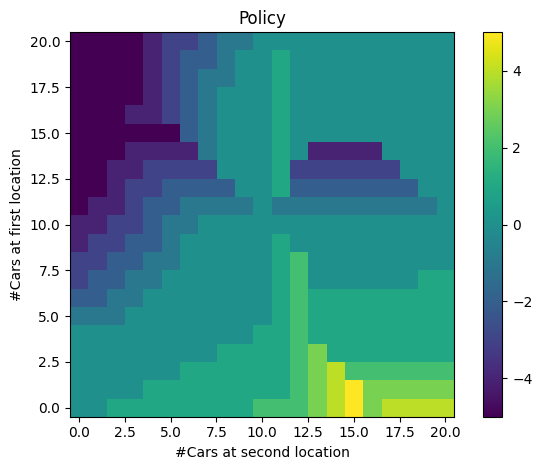

In [14]:
plt.figure()
plt.title("Policy")
plt.ylabel("#Cars at first location")
plt.xlabel("#Cars at second location")
plt.imshow(policies , origin='lower',
            vmin=-5, vmax=+5)
plt.colorbar()
plt.tight_layout()
plt.savefig('../chapters_latex/figures/ex_04_07_modified.pdf')

This might not be 100% correct, as I couldn't compare it to anything. It's good to note that the solutions I have found didn't replicate the original plot in the book (or maybe the exercise in the book changed?).

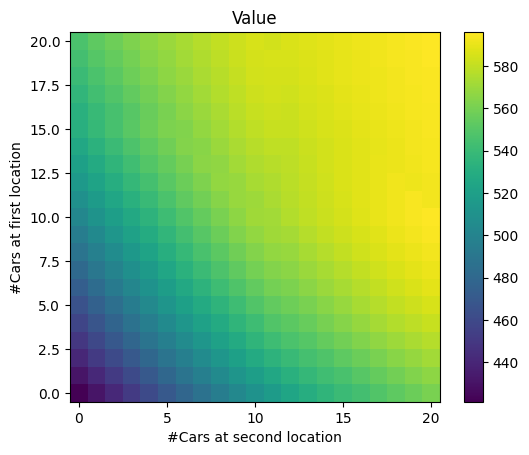

In [15]:
plt.figure()
plt.title("Value")
plt.ylabel("#Cars at first location")
plt.xlabel("#Cars at second location")
plt.imshow(values , origin='lower')
plt.colorbar()